## **Notebook to make predictions with reprocessed Henson data and SPOT**

By Christina Schenk and Garrett Roell

Tested on biodesign_3.7 kernel on jprime

### SPOT predictions and evaluations
This notebook predicts fluxes for R. opacus cultures growing with phenol. The data was published in [Henson (2018)](https://www.sciencedirect.com/science/article/pii/S1096717618300910).

#### **Data Labels:**
                                                 
#### Henson:
* WT 0.5g/L Phenol 		(**WT-P**)
* PVHG6 0.5g/L  Phenol 	(**PVHG-P**)

### Method: 
<ul>
    <li>WT</li>
    <ol>    
    <li>Predict fluxes with SPOT</li>
    <li>Compare predictions with 13CMFA: Scatter plots and flux maps</li>
   </ol>
    <li>PVHG</li>
    <ol>    
    <li>Predict fluxes with SPOT</li>
    <li>Compare predictions with 13CMFA: Scatter plots and flux maps</li>
   </ol>
</ul>

3. Load file with observed growth rates (Notebook E)
    
4. Compare growth rate predictions with growth rate observations



#### **Set up imports**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import cobra
import scipy.stats
#import cplex
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.image as mpimg
import matplotlib.cm as cm

from edd_utils import login, export_study, export_metadata

from sklearn.metrics import r2_score

output_dir = '../plots/'
source_dir = '../src'
sys.path.append(source_dir)
from ensemblemethods import *


from plot import *
from utils import *

#### **Load Genome Scale Model**

In [2]:
model = cobra.io.read_sbml_model("../models/Ropacus_annotated_curated.xml")

#### **Load Transcript Data**

In [3]:
# read transcripts and isolate wildtype phenol data and adapted strain wildtype data
transcript_df = pd.read_csv('../data/transcripts/csv/henson_CPM_melted.csv')
transcript_df_wt = transcript_df[transcript_df['Line Name'].str.contains("WT-P")]
transcript_df_pvhg = transcript_df[transcript_df['Line Name'].str.contains("PVHG-P")]

#### **Run SPOT for Each Wild Type Trial**

In [4]:
# create dictionary to hold spot solutions
spot_solutions_wt = {}

for trial in ['WT-P-R1', 'WT-P-R2','WT-P-R3']:

    # display trial name
    trial_number = trial.split('-R')[1]
    trial_name = f'phenol_spot_wt_{trial_number}'
    print(trial_name)

    transcriptomics = transcript_df_wt[transcript_df_wt['Line Name'] == trial]

    # map the transcripts to genome scale reactions
    trans_data = construct_trans_df(transcriptomics, trial)

    # run spot to get genome scale fluxes
    spot_sol = spot_pred(model, trans_data, trial, 'phenol', sub_uptake_rate=100)

    print(f"The phenol uptake rate is {spot_sol['EX_phenol_e']}")

    # add spot solution to dictionary
    spot_solutions_wt[trial_name] = spot_sol

phenol_spot_wt_1


{'EX_ca2_e': inf,
 'EX_cl_e': inf,
 'EX_cobalt2_e': inf,
 'EX_cu2_e': inf,
 'EX_fe2_e': inf,
 'EX_fe3_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_k_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_mobd_e': inf,
 'EX_nh4_e': inf,
 'EX_o2_e': inf,
 'EX_pi_e': inf,
 'EX_so4_e': inf,
 'EX_zn2_e': inf,
 'EX_phenol_e': inf}

The phenol uptake rate is -0.02678778794648709
phenol_spot_wt_2


{'EX_ca2_e': inf,
 'EX_cl_e': inf,
 'EX_cobalt2_e': inf,
 'EX_cu2_e': inf,
 'EX_fe2_e': inf,
 'EX_fe3_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_k_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_mobd_e': inf,
 'EX_nh4_e': inf,
 'EX_o2_e': inf,
 'EX_pi_e': inf,
 'EX_so4_e': inf,
 'EX_zn2_e': inf,
 'EX_phenol_e': inf}

The phenol uptake rate is -0.04855242488122243
phenol_spot_wt_3


{'EX_ca2_e': inf,
 'EX_cl_e': inf,
 'EX_cobalt2_e': inf,
 'EX_cu2_e': inf,
 'EX_fe2_e': inf,
 'EX_fe3_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_k_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_mobd_e': inf,
 'EX_nh4_e': inf,
 'EX_o2_e': inf,
 'EX_pi_e': inf,
 'EX_so4_e': inf,
 'EX_zn2_e': inf,
 'EX_phenol_e': inf}

The phenol uptake rate is -0.06865061476191596


#### **Run SPOT for Each Adapted Strain (PVHG) Trial**

In [5]:
# create dictionary to hold spot solutions
spot_solutions_pvhg = {}

for trial in ['PVHG-P-R1', 'PVHG-P-R2','PVHG-P-R3']:

    # display trial name
    trial_number = trial.split('-R')[1]
    trial_name = f'phenol_spot_pvhg_{trial_number}'
    print(trial_name)

    transcriptomics = transcript_df_pvhg[transcript_df_pvhg['Line Name'] == trial]

    # map the transcripts to genome scale reactions
    trans_data = construct_trans_df(transcriptomics, trial)

    # run spot to get genome scale fluxes
    spot_sol = spot_pred(model, trans_data, trial, 'phenol', sub_uptake_rate=100)

    print(f"The phenol uptake rate is {spot_sol['EX_phenol_e']}")

    # add spot solution to dictionary
    spot_solutions_pvhg[trial_name] = spot_sol

phenol_spot_pvhg_1


{'EX_ca2_e': inf,
 'EX_cl_e': inf,
 'EX_cobalt2_e': inf,
 'EX_cu2_e': inf,
 'EX_fe2_e': inf,
 'EX_fe3_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_k_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_mobd_e': inf,
 'EX_nh4_e': inf,
 'EX_o2_e': inf,
 'EX_pi_e': inf,
 'EX_so4_e': inf,
 'EX_zn2_e': inf,
 'EX_phenol_e': inf}

The phenol uptake rate is -0.01131753545771845
phenol_spot_pvhg_2


{'EX_ca2_e': inf,
 'EX_cl_e': inf,
 'EX_cobalt2_e': inf,
 'EX_cu2_e': inf,
 'EX_fe2_e': inf,
 'EX_fe3_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_k_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_mobd_e': inf,
 'EX_nh4_e': inf,
 'EX_o2_e': inf,
 'EX_pi_e': inf,
 'EX_so4_e': inf,
 'EX_zn2_e': inf,
 'EX_phenol_e': inf}

The phenol uptake rate is -0.01261800445461906
phenol_spot_pvhg_3


{'EX_ca2_e': inf,
 'EX_cl_e': inf,
 'EX_cobalt2_e': inf,
 'EX_cu2_e': inf,
 'EX_fe2_e': inf,
 'EX_fe3_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_k_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_mobd_e': inf,
 'EX_nh4_e': inf,
 'EX_o2_e': inf,
 'EX_pi_e': inf,
 'EX_so4_e': inf,
 'EX_zn2_e': inf,
 'EX_phenol_e': inf}

The phenol uptake rate is -0.013246667762716569


#### **Save Phenol WT SPOT Genome Scale Fluxes**

In [6]:
# loop over solution dictionary. Convert the flux solutions, convert each to a dataframe and save as csv
for trial_name, flux_solution in spot_solutions_wt.items():

    flux_df = spot_solution_to_df(model, flux_solution)
    flux_df.to_csv(f'../data/genome_scale_fluxes/{trial_name}.csv', index=False)

    display(flux_df.head(5))

,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,-3.039521e-12
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,6.938894e-18
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,-3.209711e-12
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,3.465896e-11
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,8.348737e-12


,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,-2.309758e-12
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,0.000000e+00
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,-3.418763e-12
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,1.372072e-11
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,-1.866284e-12


,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,-2.107899e-13
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,-1.387779e-17
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,-5.332159e-13
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,6.284099e-12
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,-2.499647e-13


#### **Save Phenol PVHG SPOT Genome Scale Fluxes**

In [7]:
# loop over solution dictionary. Convert the flux solutions, convert each to a dataframe and save as csv
for trial_name, flux_solution in spot_solutions_pvhg.items():

    flux_df = spot_solution_to_df(model, flux_solution)
    flux_df.to_csv(f'../data/genome_scale_fluxes/{trial_name}.csv', index=False)

    display(flux_df.head(5))

,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,-3.074635e-12
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,0.000000e+00
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,-1.025740e-11
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,2.558063e-11
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,1.254793e-11


,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,9.069585e-12
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,-1.734723e-18
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,-1.063559e-12
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,2.906499e-11
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,2.126684e-12


,reaction_id,reaction_name,reaction_reaction,flux
0,12DGR140tipp,"1,2 diacylglycerol transport via flipping (per...",12dgr140_p --> 12dgr140_c,-7.571753e-13
1,13PPDH,"1,3-propanediol dehydrogenase",3hppnl_c + h_c + nadh_c <=> 13ppd_c + nad_c,-1.734723e-18
2,1P2CBXLCYCL,1 Pyrroline 2 carboxylate cyclation,5a2opntn_c <=> 1p2cbxl_c + h2o_c + h_c,-3.679790e-12
3,1P2CBXLR,Delta1 piperideine 2 carboxylate reductase,1p2cbxl_c + 2.0 h_c + nadph_c --> nadp_c + pro...,1.305593e-11
4,23CTI1,Decenyl coa cis trans isomerization cis dec 3...,decoa_c --> dc2coa_c + h_c,5.124542e-12


#### **Get Average and Standard Deviation of WT Genome Scale Fluxes**

In [8]:
# can curate trials to use
relevant_trials = [
    'phenol_spot_wt_1', 
    'phenol_spot_wt_2', 
    'phenol_spot_wt_3',
]

# define constants to use below
uptake_reaction = 'EX_phenol_e'
normalized_uptake_rate = -100

# get list of relevant flux vectors
flux_vectors = [spot_solutions_wt[trial_name] for trial_name in relevant_trials]

# combine into a single dataframe, and name the columns
all_flux_vector_df = pd.concat(flux_vectors, axis=1)
all_flux_vector_df.columns = relevant_trials

# scale columns so that all have the same uptake rate
for trial in relevant_trials:
    # get the uptake rate for the trial
    current_uptake_rate = all_flux_vector_df[trial][uptake_reaction]
    
    # calculate the scale factor to get the ratio of the current uptake rate to the normalized uptake value
    scale_factor = normalized_uptake_rate / all_flux_vector_df[trial][uptake_reaction]

    # update the fluxes in the dataframe with scaled fluxes
    all_flux_vector_df[trial] = scale_factor * all_flux_vector_df[trial]

# calculate average and standard deviation of flux vectors
average_spot_solution_wt = pd.DataFrame(all_flux_vector_df.mean(axis=1), columns=['fluxes'])
std_spot_solution_wt =  pd.DataFrame(all_flux_vector_df.std(axis=1), columns=['stds'])

# save average flux vector
average_spot_solution_wt.to_csv('../data/genome_scale_fluxes/phenol_spot.csv')

display(average_spot_solution_wt.head())
display(std_spot_solution_wt.head())

,fluxes
12DGR140tipp,-5.470320e-09
13PPDH,1.896034e-15
1P2CBXLCYCL,-6.600029e-09
1P2CBXLR,5.559892e-08
23CTI1,8.986080e-09


,stds
12DGR140tipp,5.554247e-09
13PPDH,2.311754e-14
1P2CBXLCYCL,5.615665e-09
1P2CBXLR,6.460939e-08
23CTI1,1.928719e-08


#### **Get average and standard deviation of Adapted Strain Genome Scale Fluxes**

In [9]:
# can curate trials to use
relevant_trials = [
    'phenol_spot_pvhg_1', 
    'phenol_spot_pvhg_2', 
    'phenol_spot_pvhg_3',
]

# define constants to use below
uptake_reaction = 'EX_phenol_e'
normalized_uptake_rate = -100

# get list of relevant flux vectors
flux_vectors = [spot_solutions_pvhg[trial_name] for trial_name in relevant_trials]

# combine into a single dataframe and name the columns
all_flux_vector_df = pd.concat(flux_vectors, axis=1)
all_flux_vector_df.columns = relevant_trials

# scale columns so that all have the same uptake rate
for trial in relevant_trials:
    # get the uptake rate for the trial
    current_uptake_rate = all_flux_vector_df[trial][uptake_reaction]
    
    # calculate the scale factor to get the ratio of the current uptake rate to the normalized uptake value
    scale_factor = normalized_uptake_rate / all_flux_vector_df[trial][uptake_reaction]

    # update the fluxes in the dataframe with scaled fluxes
    all_flux_vector_df[trial] = scale_factor * all_flux_vector_df[trial]

# calculate average and standard deviation of flux vectors
average_spot_solution_pvhg = pd.DataFrame(all_flux_vector_df.mean(axis=1), columns=['fluxes'])
std_spot_solution_pvhg =  pd.DataFrame(all_flux_vector_df.std(axis=1), columns=['stds'])

display(average_spot_solution_pvhg.head())
display(std_spot_solution_pvhg.head())

,fluxes
12DGR140tipp,1.299838e-08
13PPDH,-8.947849e-15
1P2CBXLCYCL,-4.228024e-08
1P2CBXLR,1.849773e-07
23CTI1,5.547050e-08


,stds
12DGR140tipp,5.210715e-08
13PPDH,7.755929e-15
1P2CBXLCYCL,4.297773e-08
1P2CBXLR,7.487066e-08
23CTI1,4.920481e-08


#### **Load Phenol 13C MFA Data**

In [10]:
phenol_fluxes = pd.read_csv('../data/central_fluxes/phenol_13C.csv')

# # Remove rows that do not have a mapping to the GSM
phenol_fluxes.dropna(subset = ["Forward Reactions"], inplace=True)
print(f'There are {len(phenol_fluxes)} fluxes that can be compared between the MFA and SPOT')

phenol_fluxes.head()

There are 44 fluxes that can be compared between the MFA and SPOT


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Substrate Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",100.0000,100.0000,100.0000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-0.4793,-1.4219,0.9306
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.0000,-2.0000,-0.7683
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.0000,-2.0000,-0.7683
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.0000,-2.0000,-0.7683


#### **Map Phenol SPOT fluxes to 13C MFA Reactions**

In [11]:
average_spot_solution_wt.head()

,fluxes
12DGR140tipp,-5.470320e-09
13PPDH,1.896034e-15
1P2CBXLCYCL,-6.600029e-09
1P2CBXLR,5.559892e-08
23CTI1,8.986080e-09


In [12]:
phenol_fluxes = add_pred_fluxes_to_13c_df(phenol_fluxes, average_spot_solution_wt,   std_spot_solution_wt,   'phenol', 'SPOT', 'WT')
phenol_fluxes = add_pred_fluxes_to_13c_df(phenol_fluxes, average_spot_solution_pvhg, std_spot_solution_pvhg, 'phenol', 'SPOT', 'PVHG')
phenol_fluxes.head()

scale_factor fluxes    1.0
Name: EX_phenol_e, dtype: float64
scale_factor fluxes    1.0
Name: EX_phenol_e, dtype: float64


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,SPOT WT Value,SPOT WT std Value,SPOT PVHG Value,SPOT PVHG std Value
0,Substrate Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",100.0000,100.0000,100.0000,1.000000e+02,2.461392e-14,1.000000e+02,5.859286e-14
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-0.4793,-1.4219,0.9306,1.593779e-07,2.036915e-07,5.298689e-07,4.565831e-07
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.0000,-2.0000,-0.7683,-2.308705e+00,3.998796e+00,5.235661e-07,5.051245e-07
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.0000,-2.0000,-0.7683,-2.308705e+00,3.998796e+00,5.807059e-07,4.003691e-07
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.0000,-2.0000,-0.7683,-4.275300e+00,2.778136e+00,-1.333791e+01,5.078263e+00


#### **Save Phenol SPOT Central Flux Predictions**

In [13]:
phenol_fluxes.to_csv('../data/central_fluxes/phenol_spot.csv', index=False)

#### **Plot WT Phenol SPOT Fluxes vs 13C MFA Fluxes**

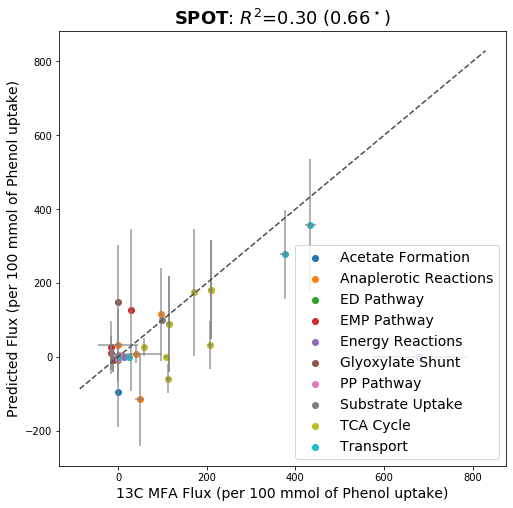

In [14]:
obs_vs_pred_scatter_plot_with_std(phenol_fluxes, substrate='phenol', method='SPOT', strain='WT', output_dir=output_dir)

#### **Plot PVHG Phenol SPOT Fluxes vs 13C MFA Fluxes**

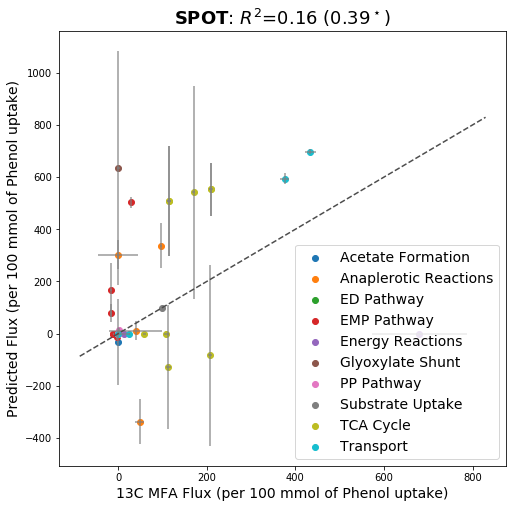

In [24]:
obs_vs_pred_scatter_plot_with_std(phenol_fluxes, substrate='phenol', method='SPOT', strain='PVHG', output_dir=output_dir)

#### **Display WT Phenol SPOT Flux Map**

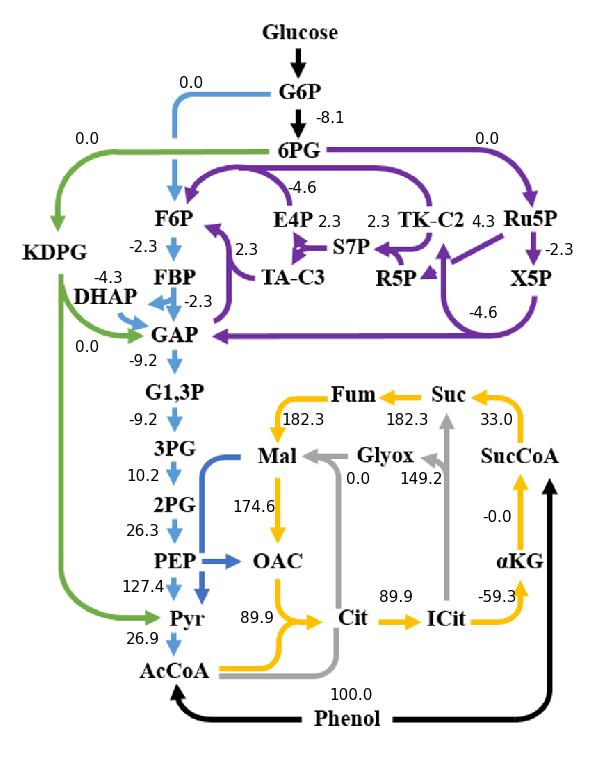

In [25]:
generate_flux_map(phenol_fluxes, 'SPOT WT Value', substrate='phenol', method='SPOT', strain='WT', output_dir=output_dir)

#### **Display PVHG Phenol SPOT Flux Map**

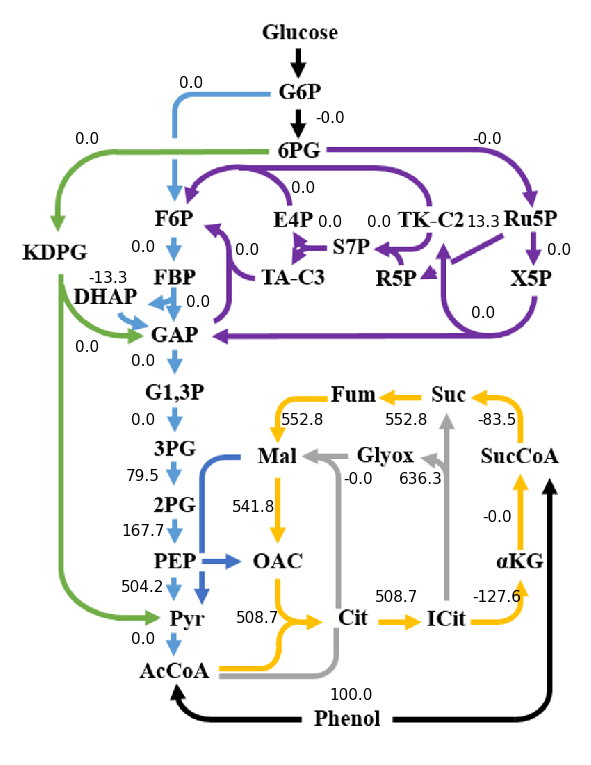

In [17]:
generate_flux_map(phenol_fluxes, 'SPOT PVHG Value', substrate='phenol', method='SPOT', strain='PVHG', output_dir=output_dir)

#### **Load experimental growth parameters and SPOT Glucose Data**

In [18]:
consumption_and_growth_data = pd.read_csv('../data/growth_rates/spot_growth_rates.csv', index_col=0)
consumption_and_growth_data

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev,SPOT growth rate,SPOT growth std
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279,NaN,NaN
PVHG-P,0.080331,0.040848,1.967485,0.002672,0.001757,0.021785,NaN,NaN
WT-G,0.260195,0.072789,3.582471,0.004749,0.004117,0.141675,-4.877742e-10,2.505973e-10


#### **Calculate WT Phenol SPOT Growth Rate**

In [19]:
# get experimental uptake rate from table
exp_uptake_rate = consumption_and_growth_data.loc['WT-P', 'substrate consumption rate']

# get average and standard deviation of growth rate from dataframes
average_growth_rate = average_spot_solution_wt.loc['Growth_Phenol',:].values[0] 
std_growth_rate = std_spot_solution_wt.loc['Growth_Phenol',:].values[0] 

# get average and standard deviation of uptake rate from dataframes
average_uptake_rate = average_spot_solution_wt.loc['EX_phenol_e',:].values[0] 
std_uptake_rate = std_spot_solution_wt.loc['EX_phenol_e',:].values[0] 

# normalize growth rate to experimental uptake rate
spot_growth_rate_wt = -1 * exp_uptake_rate * (average_growth_rate / average_uptake_rate)
spot_growth_rate_std_wt = -1 * exp_uptake_rate * (std_growth_rate / average_uptake_rate)

# Delete later
print(exp_uptake_rate)
print(average_growth_rate)
print('average uptake rate', average_uptake_rate)

1.3520722607432194
-2.2322768260231632e-08
average uptake rate -100.0


#### **Calculate PVHG Phenol SPOT Growth Rate**

In [20]:
# get experimental uptake rate from table
exp_uptake_rate = consumption_and_growth_data.loc['PVHG-P', 'substrate consumption rate']

# get average and standard deviation of growth rate from dataframes
average_growth_rate = average_spot_solution_pvhg.loc['Growth_Phenol',:].values[0] 
std_growth_rate = std_spot_solution_pvhg.loc['Growth_Phenol',:].values[0] 

# get average and standard deviation of uptake rate from dataframes
average_uptake_rate = average_spot_solution_pvhg.loc['EX_phenol_e',:].values[0] 
std_uptake_rate = std_spot_solution_pvhg.loc['EX_phenol_e',:].values[0] 

# normalize growth rate to experimental uptake rate
spot_growth_rate_pvhg = -1 * exp_uptake_rate * (average_growth_rate / average_uptake_rate)
spot_growth_rate_std_pvhg = -1 * exp_uptake_rate * (std_growth_rate / average_uptake_rate)

# Delete later
print(exp_uptake_rate)
print(average_growth_rate)
print('average uptake rate', average_uptake_rate)

1.96748494522118
-7.073556294303789e-08
average uptake rate -100.0


#### **Add Phenol SPOT Data to E-Flux Growth Rate Data**

In [21]:
# get values added in notebook G
spot_growth_rate_glucose = float(consumption_and_growth_data.loc['WT-G']['SPOT growth rate'])
spot_growth_rate_std_glucose = float(consumption_and_growth_data.loc['WT-G']['SPOT growth std'])


consumption_and_growth_data['SPOT growth rate'] = [
    spot_growth_rate_wt, spot_growth_rate_pvhg, spot_growth_rate_glucose
]
consumption_and_growth_data['SPOT growth std'] = [
    spot_growth_rate_std_wt, spot_growth_rate_std_pvhg, spot_growth_rate_std_glucose
]
consumption_and_growth_data

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev,SPOT growth rate,SPOT growth std
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279,-3.018200e-10,3.482671e-10
PVHG-P,0.080331,0.040848,1.967485,0.002672,0.001757,0.021785,-1.391712e-09,1.279382e-09
WT-G,0.260195,0.072789,3.582471,0.004749,0.004117,0.141675,-4.877742e-10,2.505973e-10


#### **Save SPOT Growth Rates**

In [22]:
consumption_and_growth_data.to_csv('../data/growth_rates/spot_growth_rates.csv', index=True, header= True)

#### **Plot SPOT Growth Rates**

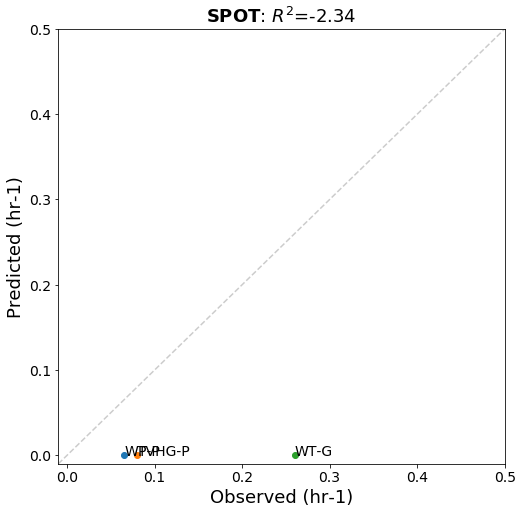

In [23]:
selectedlist = ['WT-P', 'PVHG-P', 'WT-G']
comparison_scatter_plot(
    consumption_and_growth_data.loc[selectedlist, 'growth rate'], 
    consumption_and_growth_data.loc[selectedlist, 'SPOT growth rate'], 
    selectedlist, 
    'SPOT',
    [-0.01, 0.5], # x limits
    [-0.01, 0.5], # y limits
    output_dir=output_dir
)